In [1]:
!pip install geemap scikit-learn --quiet --no-cache-dir

get landsat data

In [2]:
import ee
import geemap
import pandas as pd

from geemap import ml
from sklearn import ensemble

In [3]:
geemap.ee_initialize()

trial using sklearn

In [4]:
url = "https://raw.githubusercontent.com/gee-community/geemap/master/examples/data/rf_example.csv"
df = pd.read_csv(url)

df

,B2,B3,B4,B5,B6,B7,landcover
0,0.139846,0.114738,0.109982,0.119542,0.125795,0.105720,0
1,0.130316,0.109207,0.107499,0.140210,0.132006,0.108497,0
2,0.146690,0.135766,0.146550,0.225686,0.218105,0.167111,0
3,0.119413,0.108924,0.105196,0.144868,0.159775,0.122056,0
4,0.155492,0.139932,0.137486,0.151377,0.153771,0.133134,0
...,...,...,...,...,...,...,...
93,0.117331,0.092176,0.062548,0.020362,0.005813,0.004047,2
94,0.118353,0.093785,0.060253,0.020083,0.007317,0.004719,2
95,0.123362,0.095831,0.069663,0.027320,0.011386,0.008357,2
96,0.122907,0.100083,0.079527,0.024564,0.008570,0.006321,2


In [5]:
feature_names = ["B2", "B3", "B4", "B5", "B6", "B7"]
label = "landcover"

In [6]:
X = df[feature_names]
y = df[label]

In [7]:
n_trees = 10
rf = ensemble.RandomForestClassifier(n_trees).fit(X, y)

In [8]:
trees = ml.rf_to_strings(rf, feature_names)

print(trees[0])

1) root 59 9999 9999 (1.1639277175985367)
  2) B3 <= 0.104331 59 0.6658 2
    4) B5 <= 0.085596 20 0.0000 2 *
    5) B5 > 0.085596 20 0.0000 1 *
  3) B3 > 0.104331 19 0.0000 0 *



In [9]:
print(trees[1])

1) root 65 9999 9999 (1.931450645533578)
  2) B3 <= 0.102493 65 0.6633 2
    4) B6 <= 0.055839 24 0.0000 2 *
    5) B6 > 0.055839 45 0.5226 2
      10) B6 <= 0.101275 1 0.0000 0 *
      11) B6 > 0.101275 20 0.0000 1 *
  3) B3 > 0.102493 65 0.6633 2
    6) B3 <= 0.107335 20 0.1284 0
      12) B3 <= 0.105324 1 0.0000 0 *
      13) B3 > 0.105324 1 0.0000 1 *
    7) B3 > 0.107335 18 0.0000 0 *



In [10]:
len(trees) == n_trees

True

conversion to classifier

In [11]:
ee_classifier = ml.strings_to_classifier(trees)
ee_classifier.getInfo()

{'type': 'Classifier.decisionTreeEnsemble',
 'treeStrings': ['1) root 59 9999 9999 (1.1639277175985367)\n  2) B3 <= 0.104331 59 0.6658 2\n    4) B5 <= 0.085596 20 0.0000 2 *\n    5) B5 > 0.085596 20 0.0000 1 *\n  3) B3 > 0.104331 19 0.0000 0 *\n',
  '1) root 65 9999 9999 (1.931450645533578)\n  2) B3 <= 0.102493 65 0.6633 2\n    4) B6 <= 0.055839 24 0.0000 2 *\n    5) B6 > 0.055839 45 0.5226 2\n      10) B6 <= 0.101275 1 0.0000 0 *\n      11) B6 > 0.101275 20 0.0000 1 *\n  3) B3 > 0.102493 65 0.6633 2\n    6) B3 <= 0.107335 20 0.1284 0\n      12) B3 <= 0.105324 1 0.0000 0 *\n      13) B3 > 0.105324 1 0.0000 1 *\n    7) B3 > 0.107335 18 0.0000 0 *\n',
  '1) root 59 9999 9999 (2.194337533394148)\n  2) B7 <= 0.020468 21 0.0000 2 *\n  3) B7 > 0.020468 59 0.6599 1\n    6) B5 <= 0.170298 7 0.0000 0 *\n    7) B5 > 0.170298 38 0.4865 1\n      14) B4 <= 0.105958 17 0.0000 1 *\n      15) B4 > 0.105958 31 0.4405 1\n        30) B3 <= 0.135390 14 0.2873 0\n          60) B7 <= 0.153320 1 0.0000 0 *\n

In [13]:
roi = ee.FeatureCollection('FAO/GAUL/2015/level0')
afg = ee.Filter.eq('ADM0_NAME', 'Afghanistan')
roi = roi.filter(afg)

def scale_factors (image):
    optical_bands = image.select('SR_B.').multiply(2.75e-05).add(-0.2)
    thermal_bands = image.select('ST_B6').multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)

def clipping (image):
    return image.clip(roi)

image_landsat5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
image_col = image_landsat5.filterDate('1990-01-01', '1990-12-31')
image_col = image_col.filterBounds(roi)
image_col = image_col.map(scale_factors)
image_col = image_col.map(clipping)

reducer = ee.Reducer.percentile([20])

image = image_col.reduce(reducer)
image = image.select(['SR_B1_p20', 'SR_B2_p20', 'SR_B3_p20', 'SR_B4_p20', 'SR_B5_p20', 'SR_B7_p20'])
image = image.rename(['B2', 'B3', 'B4', 'B5', 'B6', 'B7'])

image

In [14]:
def get_series (startY, endY, startM, endM):
    image_col = ee.ImageCollection("LANDSAT/LC08/C01/T1").filterBounds(roi)
    image_col = image_col.filter(ee.Filter.calendarRange(startY, endY, 'year')).filter(ee.Filter.calendarRange(startM, endM, 'month'))
    image_col = image_col.filter(ee.Filter.lt('CLOUD_COVER', 20))
    


In [15]:
classify = image.select(feature_names).classify(ee_classifier)

In [16]:
Map = geemap.Map(center=(34.28, 66.28), zoom=6)

vis_image = {
    "min" : 0.05,
    "max" : 0.55,
    "gamma" : 1.5,
    "bands" : ['B7', 'B5', 'B3']
}

vis_class = {
    "min" : 0,
    "max" : 2,
    "palette" : [
        '76a680', # Forest
        'c08c4d', # Rangeland
        '211f3a', # Waterbodies
    ]
}

Map.addLayer(image, vis_image, "image")
Map.addLayer(classify, vis_class, "classification")

Map

Map(center=[34.28, 66.28], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

asset convert

In [17]:
user_id = geemap.ee_user_id()
user_id

'users/aprilia_gicait'

In [18]:
asset_id = user_id + "/random_forest_strings_test"
asset_id

'users/aprilia_gicait/random_forest_strings_test'

In [19]:
ml.export_trees_to_fc(trees, asset_id)

In [20]:
rf_fc = ee.FeatureCollection(asset_id)

another_classifier = ml.fc_to_classifier(rf_fc)
classified = image.select(feature_names).classify(another_classifier)

In [21]:
# display results
# we should get the exact same results as before
Map = geemap.Map(center=(37.75, -122.25), zoom=11)

Map.addLayer(
    image,
    {"bands": ["B7", "B5", "B3"], "min": 0.05, "max": 0.55, "gamma": 1.5},
    "image",
)
Map.addLayer(
    classified,
    {"min": 0, "max": 2, "palette": ["red", "green", "blue"]},
    "classification",
)

Map

Map(center=[37.75, -122.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

local saving

In [22]:
import os

out_csv = os.path.expanduser("~/Downloads/trees.csv")

In [23]:
ml.trees_to_csv(trees, out_csv)

In [24]:
another_classifier = ml.csv_to_classifier(out_csv)

In [25]:
classified = image.select(feature_names).classify(another_classifier)

In [26]:
# display results
# we should get the exact same results as before
Map = geemap.Map(center=(37.75, -122.25), zoom=11)

Map.addLayer(
    image,
    {"bands": ["B7", "B5", "B3"], "min": 0.05, "max": 0.55, "gamma": 1.5},
    "image",
)
Map.addLayer(
    classified,
    {"min": 0, "max": 2, "palette": ["red", "green", "blue"]},
    "classification",
)

Map

Map(center=[37.75, -122.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

add more classification according to random forest

In [27]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pprint
from collections import Counter
import joblib
from pprint import pprint
import cv2

ImportError: DLL load failed while importing cv2: The specified module could not be found.

# Using EarthPy

In [29]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

In [30]:
data = et.data.get_data("vignette-landsat")

In [31]:
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))
landsat_path = glob(
    "data/vignette-landsat/LC08_L1TP_034032_20160621_20170221_01_T1_sr_band*_crop.tif"
)
landsat_path.sort()
arr_st, meta = es.stack(landsat_path, nodata=-9999)

In [32]:
ndvi = es.normalized_diff(arr_st[4], arr_st[3])

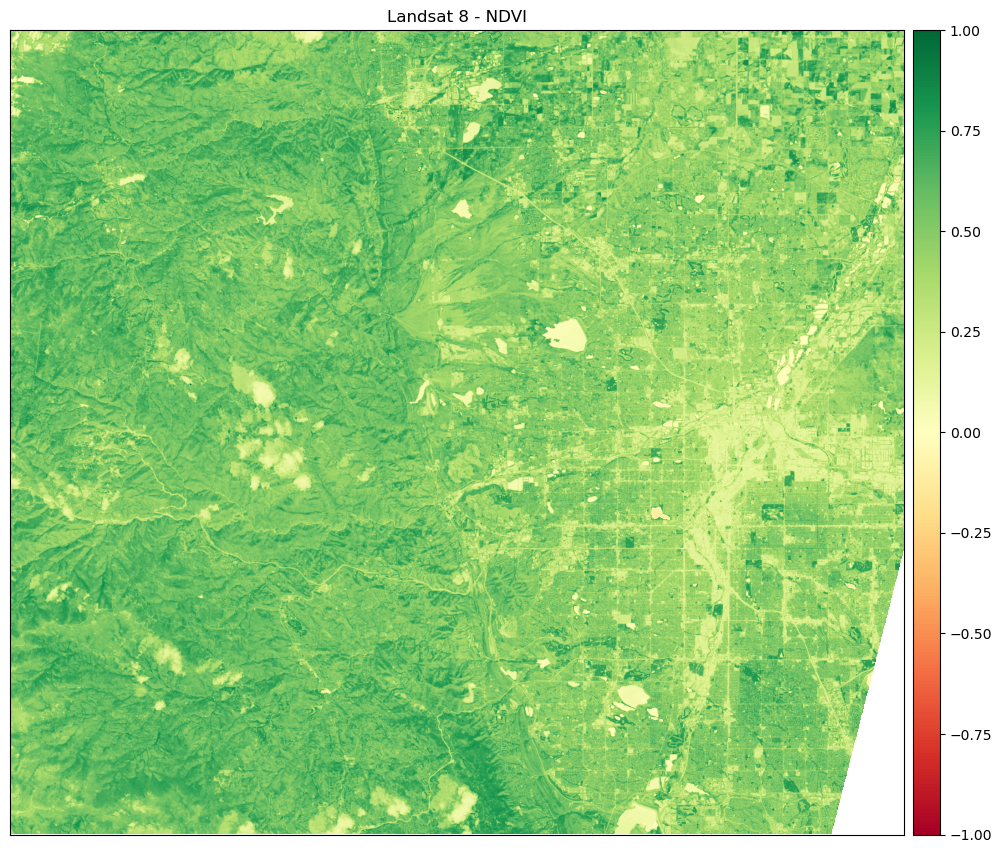

<Axes: title={'center': 'Landsat 8 - NDVI'}>

In [33]:
ep.plot_bands(ndvi, cmap="RdYlGn", cols=1, title="Landsat 8 - NDVI", vmin=-1, vmax=1)

In [34]:
ndvi_class_bins = [-np.inf, 0, 0.1, 0.25, 0.4, np.inf]
ndvi_landsat_class = np.digitize(ndvi, ndvi_class_bins)

ndvi_landsat_class = np.ma.masked_where(
    np.ma.getmask(ndvi), ndvi_landsat_class
)
np.unique(ndvi_landsat_class)

masked_array(data=[1, 2, 3, 4, 5, --],
             mask=[False, False, False, False, False,  True],
       fill_value=999999,
            dtype=int64)

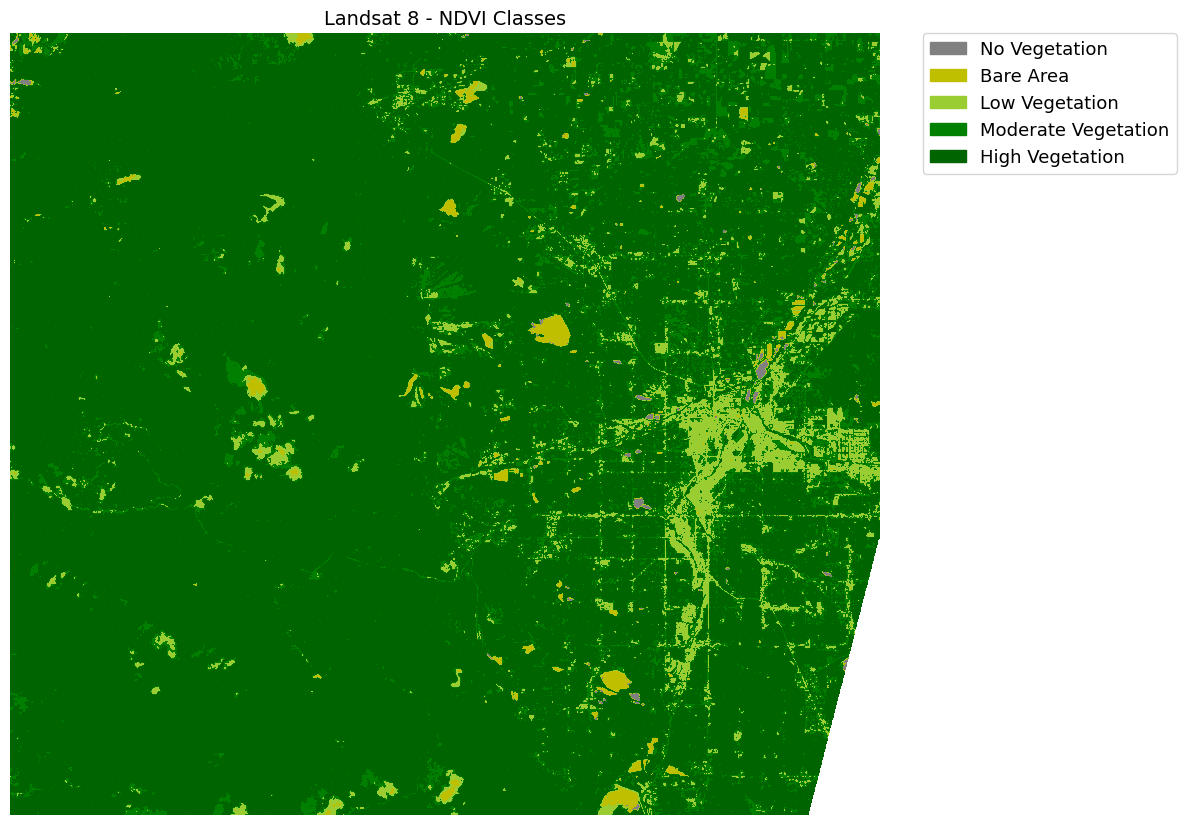

In [35]:
nbr_colors = ["gray", "y", "yellowgreen", "g", "darkgreen"]
nbr_cmap = ListedColormap(nbr_colors)

ndvi_cat_names = [
    "No Vegetation",
    "Bare Area",
    "Low Vegetation",
    "Moderate Vegetation",
    "High Vegetation",
]

classes = np.unique(ndvi_landsat_class)
classes = classes.tolist()
classes = classes[0:5]

fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(ndvi_landsat_class, cmap=nbr_cmap)

ep.draw_legend(im_ax=im, classes=classes, titles=ndvi_cat_names)
ax.set_title(
    "Landsat 8 - NDVI Classes",
    fontsize = 14,
)
ax.set_axis_off()

plt.tight_layout()

# Classification